In [ ]:
# UPDATE 9/28/2022: I AM AWARE THAT USING A MACHINE LEARNING MODEL WAS NOT NECESSARY FOR THIS PROJECT. A SIMPLE 2-DIMENSIONAL
# LINEAR REGRESSION CALCULATION WOULD HAVE ACHIEVED THE SAME GOAL (SEE README FILE IN GITHUB REPOSITORY FOR MORE INFO
# ABOUT THIS).

In [1]:
# Imports
import pandas as pd
import requests
import mysql.connector
import os
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# API URL

# NOTE: I have replaced the actual API URL with a generic string for privacy
url = 'API_URL'

In [3]:
# Making API Call
response = requests.get(url).json()

In [5]:
# Creating Pandas Dataframe
backtest_df = pd.DataFrame(columns=['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 'MACD',
                                    'Signal','Histogram', '5 Day Max', '5 Day Min'])

In [6]:
# Inputting API data into dataframe
for daynumber, day in enumerate(response['results']):
    backtest_df = backtest_df.append({'Day Number' : int(daynumber), 'Close' : day['c'], '12 Day EMA' : None,
                                      '26 Day EMA' : None, 'MACD' : None, 'Signal' : None, 'Histogram' : None,
                                      '5 Day Max' : None, '5 Day Min' : None}, ignore_index=True)

In [7]:
# Adjusting Dataframe
backtest_df['Day Number'] = backtest_df['Day Number'].astype(int)

In [9]:
# Connection details

# NOTE: I have replaced the actual hostname, username, and password with generic strings for privacy

hostname = 'AWS_HOSTNAME'
username = 'USERNAME'
my_password = 'PASSWORD'

In [10]:
# connecting to AWS database
try:
    db = mysql.connector.connect(host=hostname, user=username, passwd=my_password)
except:
    print('failed')
else:
    print('Connected')

Connected


In [11]:
mycursor = db.cursor(buffered=True)

In [12]:
try:
    mycursor.execute('DROP DATABASE IF EXISTS Stock_Data')
    db.commit()
except:
    print('failed')

In [13]:
# Creating the AAPL database
mycursor.execute('CREATE DATABASE IF NOT EXISTS Stock_Data')

In [14]:
# Creating the backtest and training tables in our database
mycursor.execute('USE Stock_Data')

# backtest table
mycursor.execute('''CREATE TABLE IF NOT EXISTS AAPL_BACKTEST (day_number INT PRIMARY KEY,
                                                            close FLOAT,
                                                            12_day_ema FLOAT,
                                                            26_day_ema FLOAT,
                                                            macd FLOAT,
                                                            signal_line FLOAT,
                                                            histogram FLOAT,
                                                            5_day_max FLOAT,
                                                            5_day_min FLOAT)''')
# training table
mycursor.execute('''CREATE TABLE IF NOT EXISTS AAPL_TRAINING_DATA (day_number INT PRIMARY KEY,
                                                                    close FLOAT,
                                                                    12_day_ema FLOAT,
                                                                    26_day_ema FLOAT,
                                                                    macd FLOAT,
                                                                    signal_line FLOAT,
                                                                    histogram FLOAT,
                                                                    5_day_max FLOAT,
                                                                    5_day_min FLOAT)''')

In [15]:
# Importing our training dataset (CSV file)

training_df = pd.read_csv('AAPL_train.csv',usecols=['Close'])

# adding columns
training_df['Day Number'] = range(len(training_df))
training_df['12 Day EMA'] = np.nan
training_df['26 Day EMA'] = np.nan
training_df['MACD'] = np.nan
training_df['Signal'] = np.nan
training_df['Histogram'] = np.nan
training_df['5 Day Max'] = np.nan
training_df['5 Day Min'] = np.nan

# rearranging columns
training_df = training_df[['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 'MACD',
                           'Signal', 'Histogram', '5 Day Max', '5 Day Min']]

In [17]:
# Calculating EMAs 
def ema(df, num_days):
    smoothing = 2
    current_values_sum = 0
    colname = str(num_days) + ' Day EMA'
    
    # Getting first EMA value
    for i in range(num_days):
        current_values_sum += df['Close'][i]
    
    # modifying initial dataframe value
    df[colname][num_days - 1] = current_values_sum / num_days 
    
    # modifying rest of dataframe values
    
    for i in range(num_days, len(df), 1):
        df[colname][i] = (df['Close'][i] * (smoothing / (1 + num_days))) + (df[colname][i - 1] * (1 - (smoothing / (1 + num_days))))
    
    return df

In [18]:
# MACD
def macd(df, min_days, max_days):
    
    mindayscol = str(min_days) + ' Day EMA'
    maxdayscol = str(max_days) + ' Day EMA'
    
    for i in range(max_days - 1, len(df), 1):
        df['MACD'][i] = df[mindayscol][i] - df[maxdayscol][i]
    
    return df
    

In [19]:
# Signal
def signal(df, num_days, ema_max_days):
    smoothing = 2
    current_values_sum = 0
    
    # Getting first EMA value
    for i in range(ema_max_days - 1, (num_days - 1) + (ema_max_days - 1) + 1, 1):
        current_values_sum += df['MACD'][i]
    
    # modifying initial dataframe value
    df['Signal'][(num_days - 1) + (ema_max_days - 1)] = current_values_sum / num_days 
    
    # modifying rest of dataframe values
    
    for i in range((num_days - 1) + (ema_max_days - 1) + 1, len(df), 1):
        df['Signal'][i] = (df['MACD'][i] * (smoothing / (1 + num_days))) + (df['Signal'][i - 1] * (1 - (smoothing / (1 + num_days))))
    
    return df

In [20]:
# Histogram
def histogram(df, signal_days, ema_max_days):
    
    initial_index = signal_days + ema_max_days - 2
    
    for i in range(initial_index, len(df), 1):
        df['Histogram'][i] = df['MACD'][i] - df['Signal'][i]
    
    return df

In [21]:
# Max and Min values of a future period
def max_min_vals(df, num_days):
    
    for i in range(len(df) - num_days):
        df[str(num_days) + ' Day Max'][i] = df['Close'][i + 1: i + num_days + 1].max()
        df[str(num_days) + ' Day Min'][i] = df['Close'][i + 1: i + num_days + 1].min()
    
    return df

In [ ]:
# Completing the training dataframe

training_df = ema(training_df, 12)
training_df = ema(training_df, 26)
training_df = macd(training_df, 12, 26)
training_df = signal(training_df, 9, 26)
training_df = histogram(training_df, 9, 26)
training_df = max_min_vals(training_df, 5)

In [ ]:
# Completing the backtesting dataframe

backtest_df = ema(backtest_df, 12)
backtest_df = ema(backtest_df, 26)
backtest_df = macd(backtest_df, 12, 26)
backtest_df = signal(backtest_df, 9, 26)
backtest_df = histogram(backtest_df, 9, 26)
backtest_df = max_min_vals(backtest_df, 5)

In [25]:
# Converts NaN (in dataframe) to NULL (in AWS database)
def null_conv(data):
    a = str(data)
    if a != 'nan':
        return a
    else:
        return None

In [26]:
# Inserting Pandas Dataframes into our database table

for i, row in backtest_df.iterrows():
    mycursor.execute('''INSERT INTO AAPL_BACKTEST (day_number, close, 12_day_ema, 26_day_ema, macd,
                        signal_line, histogram, 5_day_max, 5_day_min)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)''', (str(row['Day Number']), str(row['Close']),
                                                            null_conv(row['12 Day EMA']), null_conv(row['26 Day EMA']),
                                                            null_conv(row['MACD']), null_conv(row['Signal']),
                                                            null_conv(row['Histogram']), null_conv(row['5 Day Max']),
                                                            null_conv(row['5 Day Min'])))

for i, row in training_df.iterrows():
    mycursor.execute('''INSERT INTO AAPL_TRAINING_DATA (day_number, close, 12_day_ema, 26_day_ema, macd,
                        signal_line, histogram, 5_day_max, 5_day_min)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)''', (str(row['Day Number']), str(row['Close']),
                                                            null_conv(row['12 Day EMA']), null_conv(row['26 Day EMA']),
                                                            null_conv(row['MACD']), null_conv(row['Signal']),
                                                            null_conv(row['Histogram']), null_conv(row['5 Day Max']),
                                                            null_conv(row['5 Day Min'])))
    

In [27]:
# commiting our inserts
db.commit()

In [28]:
# Creating our new dataframes that will be used for our machine learning models
backtest_pos_vals = pd.DataFrame(columns=['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 
                                           'MACD','Signal', 'Histogram', '5 Day Min'])

backtest_neg_vals = pd.DataFrame(columns=['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 
                                           'MACD','Signal', 'Histogram', '5 Day Max'])

train_pos_vals = pd.DataFrame(columns=['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 
                                           'MACD','Signal', 'Histogram', '5 Day Min'])

train_neg_vals = pd.DataFrame(columns=['Day Number', 'Close', '12 Day EMA', '26 Day EMA', 
                                           'MACD','Signal', 'Histogram', '5 Day Max'])

In [29]:
# Loading data from our AWS database into our empty dataframes

# positve histogram values (backtest)
mycursor.execute('''SELECT day_number, close, 12_day_ema, 26_day_ema, macd, signal_line, histogram, 5_day_min 
                    FROM AAPL_BACKTEST
                    WHERE histogram > 0 AND 5_day_min IS NOT NULL''')
for i in mycursor:
    backtest_pos_vals = backtest_pos_vals.append({'Day Number' : i[0], 'Close' : i[1], '12 Day EMA' : i[2], '26 Day EMA' : i[3],
                                                  'MACD' : i[4], 'Signal' : i[5], 'Histogram' : i[6], '5 Day Min' : i[7]}, 
                                                     ignore_index=True)
# Negative histogram values (backtest)
mycursor.execute('''SELECT day_number, close, 12_day_ema, 26_day_ema, macd, signal_line, histogram, 5_day_max
                    FROM AAPL_BACKTEST
                    WHERE histogram < 0 AND 5_day_max IS NOT NULL''')
for i in mycursor:
    backtest_neg_vals = backtest_neg_vals.append({'Day Number' : i[0], 'Close' : i[1], '12 Day EMA' : i[2], '26 Day EMA' : i[3],
                                                  'MACD' : i[4], 'Signal' : i[5], 'Histogram' : i[6], '5 Day Max' : i[7]},
                                                    ignore_index=True)
# Positive histogram values (training)
mycursor.execute('''SELECT day_number, close, 12_day_ema, 26_day_ema, macd, signal_line, histogram, 5_day_min 
                    FROM AAPL_TRAINING_DATA
                    WHERE histogram > 0 AND 5_day_min IS NOT NULL''')
for i in mycursor:
    train_pos_vals = train_pos_vals.append({'Day Number' : i[0], 'Close' : i[1], '12 Day EMA' : i[2], '26 Day EMA' : i[3],
                                      'MACD' : i[4], 'Signal' : i[5], 'Histogram' : i[6], '5 Day Min' : i[7]}, 
                                        ignore_index=True)
    
# Negative histogram values (training)
mycursor.execute('''SELECT day_number, close, 12_day_ema, 26_day_ema, macd, signal_line, histogram, 5_day_max
                    FROM AAPL_TRAINING_DATA
                    WHERE histogram < 0 AND 5_day_max IS NOT NULL''')
for i in mycursor:
    train_neg_vals = train_neg_vals.append({'Day Number' : i[0], 'Close' : i[1], '12 Day EMA' : i[2], '26 Day EMA' : i[3],
                                      'MACD' : i[4], 'Signal' : i[5], 'Histogram' : i[6], '5 Day Max' : i[7]}, 
                                           ignore_index=True)

In [30]:
# Adjusting Dataframes
backtest_pos_vals['Day Number'] = backtest_pos_vals['Day Number'].astype(int)
backtest_neg_vals['Day Number'] = backtest_neg_vals['Day Number'].astype(int)
train_pos_vals['Day Number'] = train_pos_vals['Day Number'].astype(int)
train_neg_vals['Day Number'] = train_neg_vals['Day Number'].astype(int)

In [31]:
# Data preprocessing for positive histogram values

# feature is histogram value
pos_train_features = train_pos_vals['Histogram'][:].to_numpy()
pos_test_features = backtest_pos_vals['Histogram'][:].to_numpy()

# label is maximum percentage decrease of the stock in the following 5 days
pos_test_labels = []
pos_train_labels = []

for i, row in backtest_pos_vals.iterrows():
    pos_test_labels.append((row['5 Day Min'] / row['Close']) - 1)

for i, row in train_pos_vals.iterrows():
    pos_train_labels.append((row['5 Day Min'] / row['Close']) - 1)

pos_test_labels = np.array(pos_test_labels)
pos_train_labels = np.array(pos_train_labels)

In [32]:
# Data preprocessing for negative histogram values

# feature is histogram value
neg_train_features = train_neg_vals['Histogram'][:].to_numpy()
neg_test_features = backtest_neg_vals['Histogram'][:].to_numpy()

# label is maximum percentage increase of the stock in the following 5 days
neg_test_labels = []
neg_train_labels = []

for i, row in backtest_neg_vals.iterrows():
    neg_test_labels.append((row['5 Day Max'] / row['Close']) - 1)

for i, row in train_neg_vals.iterrows():
    neg_train_labels.append((row['5 Day Max'] / row['Close']) - 1)

neg_test_labels = np.array(neg_test_labels)
neg_train_labels = np.array(neg_train_labels)

In [33]:
# building the models
pos_model = keras.models.Sequential([
        keras.Input(shape=(1,)),
        keras.layers.Dense(units=1)
    ])

neg_model = keras.models.Sequential([
        keras.Input(shape=(1,)),
        keras.layers.Dense(units=1)
    ])

loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam()

pos_model.compile(optimizer=optimizer, loss=loss)
neg_model.compile(optimizer=optimizer, loss=loss)

pos_model.summary()
neg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


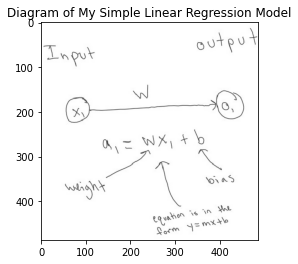

In [34]:
# showing the architecture of my simple linear regression model
model_image = keras.preprocessing.image.load_img('Model_Diagram.jpg', target_size=(487, 486))
model_diagram_arr = keras.preprocessing.image.img_to_array(model_image)
plt.imshow(model_diagram_arr.astype('uint8'))
title = plt.title("Diagram of My Simple Linear Regression Model")


# UPDATE 9/28/2022: I AM AWARE THAT USING A MACHINE LEARNING MODEL WAS NOT NECESSARY FOR THIS PROJECT. A SIMPLE 2-DIMENSIONAL
# LINEAR REGRESSION CALCULATION WOULD HAVE ACHIEVED THE SAME GOAL (SEE README FILE IN GITHUB REPOSITORY FOR MORE INFO
# ABOUT THIS).

In [35]:
# Training positive model
pos_info = pos_model.fit(pos_train_features, pos_train_labels, epochs=64, verbose=1)

Epoch 1/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0599
Epoch 2/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 3/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 4/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 5/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 6/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 7/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 8/64
23/23 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 9/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 10/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 11/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 12/64
23/23 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 13/64
23/23 [==============================

In [36]:
# Training negative model
neg_info = neg_model.fit(neg_train_features, neg_train_labels, epochs=64, verbose=1)

Epoch 1/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 2/64
24/24 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 3/64
24/24 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 4/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 5/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 6/64
24/24 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 7/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 8/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 9/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 10/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 11/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 12/64
24/24 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 13/64
24/24 [==============================

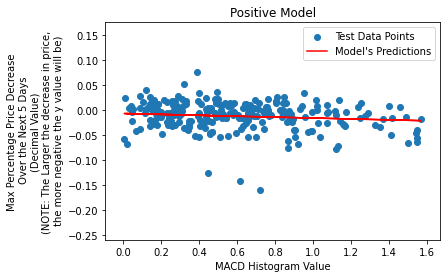

In [47]:
# Plotting the positive test data along with the model's predictions for all included domain values 
plt.scatter(pos_test_features, pos_test_labels, label='Test Data Points')
plt.plot(pos_test_features, pos_model.predict((pos_test_features[:],)), 'r', label='Model\'s Predictions')
plt.legend()
plt.axis([pos_test_features.min() - 0.1, pos_test_features.max() + 0.1, pos_test_labels.min() - 0.1, pos_test_labels.max() + 0.1])
plt.title('Positive Model')
plt.xlabel('MACD Histogram Value')
plt.ylabel('Max Percentage Price Decrease\n Over the Next 5 Days\n(Decimal Value)\n(NOTE: The Larger the decrease in price,\n the more negative the y value will be)')
lgnd = plt.legend()

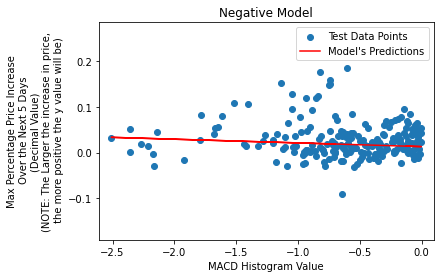

In [48]:
# Plotting the negative test data along with the model's predictions for all included domain values 
plt.scatter(neg_test_features, neg_test_labels, label='Test Data Points')
plt.plot(neg_test_features, neg_model.predict((neg_test_features[:],)), 'r', label='Model\'s Predictions')
plt.axis([neg_test_features.min() - 0.1, neg_test_features.max() + 0.1, neg_test_labels.min() - 0.1, neg_test_labels.max() + 0.1])
plt.title('Negative Model')
plt.xlabel('MACD Histogram Value')
plt.ylabel('Max Percentage Price Increase\n Over the Next 5 Days\n(Decimal Value)\n(NOTE: The Larger the increase in price,\n the more positive the y value will be)')
lgnd = plt.legend()

In [45]:
# Slopes of the prediction lines
neg_weight = neg_model.layers[0].get_weights()[0][0][0]
pos_weight = pos_model.layers[0].get_weights()[0][0][0]
print('Slope of Negative Model Prediction Line: ' + str(neg_weight))
print('Slope of Positive Model Prediction Line: ' + str(pos_weight))

Slope of Negative Model Prediction Line: -0.008067438
Slope of Positive Model Prediction Line: -0.009077326
